<a href="https://colab.research.google.com/github/cantaruttim/Rotinas/blob/main/Carteira_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
from datetime import date
import sys

In [4]:
# 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'CMIG4.SA', 'GGBR4.SA', 'ITSA4.SA', 'PETR4.SA', 'TAEE11.SA',
acoes = ['VINO11.SA', 'VGIA11.SA', 'GALG11.SA', 'VGHF11.SA']
data_atual = date.today()

dataset = yf.download(acoes, start='2023-01-04',end=data_atual)['Close']
dataset

[*********************100%%**********************]  4 of 4 completed


,GALG11.SA,VGHF11.SA,VGIA11.SA,VINO11.SA
Date,,,,
2023-01-04,9.13,9.14,9.91,9.436
2023-01-05,9.18,9.10,9.95,9.342
2023-01-06,9.11,9.11,9.98,9.580
2023-01-09,9.11,9.15,9.97,9.468
2023-01-10,9.13,9.19,9.99,9.404
...,...,...,...,...
2023-10-10,9.25,9.48,9.48,8.260
2023-10-11,9.25,9.50,9.52,8.310
2023-10-13,9.25,9.53,9.39,8.340


In [5]:
## valores atuais

vino = round(dataset['VINO11.SA'][-1], 5)
vgia = round(dataset['VGIA11.SA'][-2], 5)
vghf = round(dataset['VGHF11.SA'][-3], 5)
galg = round(dataset['GALG11.SA'][-4], 5)

vino, vgia, vghf, galg

(8.39, 9.37, 9.53, 9.25)

In [39]:
## valores médio de cada ação

# dataset.describe().T

mGALG = round(dataset['GALG11.SA'].mean(), 2)
mVGHF = round(dataset['VGHF11.SA'].mean(), 2)
mVGIA = round(dataset['VGIA11.SA'].mean(), 2)
mVINO = round(dataset['VINO11.SA'].mean(), 2)

mediaAcoes = [mGALG, mVGHF, mVGIA, mVINO]

In [40]:
mediaAcoes

[8.85, 9.3, 9.58, 8.8]

In [41]:
dataset.to_csv('acoes.csv')

In [42]:
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
  dataset = dataset.copy()

  if seed != 0:
    np.random.seed(seed)

  if len(melhores_pesos) > 0:
    pesos = melhores_pesos
  else:
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()


  colunas = dataset.columns[1:]
  for i in colunas:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns[1:]):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  dataset['soma valor'] = dataset.sum(axis = 1)

  datas = dataset['Date']

  dataset.drop(labels = ['Date'], axis = 1, inplace = True)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

  acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos * 100})

  return dataset, datas, acoes_pesos, dataset.loc[len(dataset) - 1]['soma valor']

In [43]:
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('acoes.csv'), 250, 10);

<ipython-input-42-9a39134fcf29>:21: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [44]:
dataset

,GALG11.SA,VGHF11.SA,VGIA11.SA,VINO11.SA,soma valor,taxa retorno
0,88.676923,2.385803,72.849050,86.088224,250.000000,0.000000
1,89.162560,2.375362,73.143092,85.230628,249.911641,-0.035343
2,88.482665,2.377972,73.363622,87.401992,251.626250,0.686086
3,88.482665,2.388413,73.290117,86.380177,250.541372,-0.431147
4,88.676923,2.398854,73.437134,85.796280,250.309191,-0.092671
...,...,...,...,...,...,...
192,89.842446,2.474552,69.688090,75.359131,237.364219,-0.568822
193,89.842446,2.479773,69.982139,75.815302,238.119660,0.318262
194,89.842446,2.487604,69.026500,76.089001,237.445550,-0.283097
195,88.774052,2.482383,68.879475,75.724066,235.859977,-0.667763


In [45]:
def evolucao_acoes(dataset, datas):

  figura = px.line(title = "Evolução do Patrimônio")
  for i in dataset.drop(columns = ['soma valor', 'taxa retorno']).columns:
    figura.add_scatter(x = datas, y = dataset[i], name = i)
    figura.update_layout(hovermode="x")

  return figura.show()

evolucao_acoes(dataset, datas)

In [46]:
def evolucao_patrimonio_investido(dataset, datas):

  figura = px.line(x = datas,
                  y = dataset['soma valor'],
                  title = 'Evolução do Patrimônio')
  return figura.show()

evolucao_patrimonio_investido(dataset, datas)

## Sharpe Ratio

In [114]:
## média histórica da selic nos últimos
taxa_selic_historico  = np.array([0.1365, 0.1283, 0.0498, 0.0255, 0.0568])
np.mean(taxa_selic_historico)

0.07938000000000002

In [115]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0

  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()

    for i in dataset.columns[1:]:
      dataset[i] = dataset[i] / dataset[i][0]

    for i, acao in enumerate(dataset.columns[1:]):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    dataset.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    dataset['soma valor'] = dataset.sum(axis = 1)
    dataset['taxa retorno'] = 0.0

    for i in range(1, len(dataset)):
      dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1])

    #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)
    retorno_esperado = np.sum(dataset['taxa retorno'].mean() * pesos) * 246
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 246, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)

    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

In [116]:
sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(pd.read_csv('acoes.csv'),
                                                                                                                                     350,
                                                                                                                                     taxa_selic_historico.mean(),
                                                                                                                                     15000)

In [117]:
## 100, 5000 => 1.2454374630888962
## 250, 15000 => 1.223707391614204

sharpe_ratio

-0.4757183293668476

In [118]:
melhores_pesos

array([0.14495296, 0.83287261, 0.0166858 , 0.00548863])

In [123]:
_, _, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('acoes.csv'), 350, melhores_pesos=melhores_pesos)

<ipython-input-42-9a39134fcf29>:21: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [124]:
acoes_pesos, soma_valor

(       Ações      Pesos
 0  GALG11.SA  14.495296
 1  VGHF11.SA  83.287261
 2  VGIA11.SA   1.668580
 3  VINO11.SA   0.548863,
 358.975349586751)

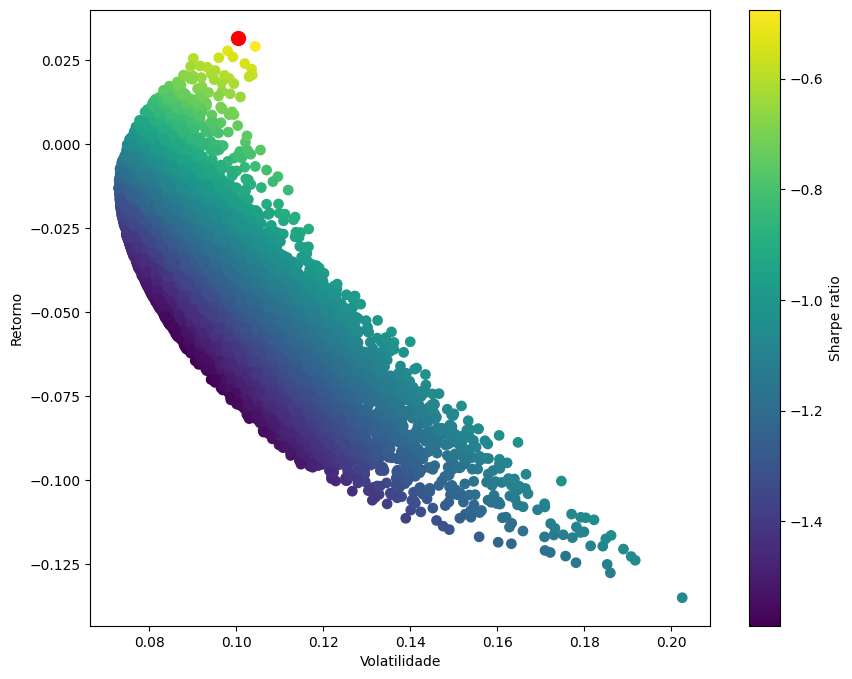

In [128]:
plt.figure(figsize=(10,8))
plt.scatter(ls_volatilidade, ls_retorno, c = ls_sharpe_ratio, s = 45)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100);

## Fundo de Investimentos

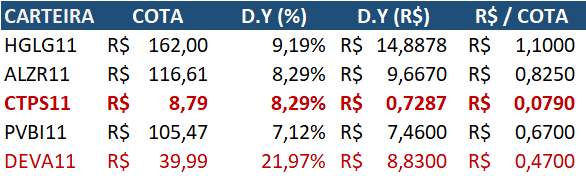

### Funções testes

In [ ]:
round(sum(df.iloc[:, 5].values), 2)

4113.56

In [ ]:
def periodo(meses):
  mesesLista = []
  for meses in range(1, meses + 1):
      mesesLista.append(f"MÊS {meses}")
  return mesesLista

meses = periodo(10)

In [ ]:
def seleciona_empresa(qtd_empresas):
  tickers = []
  analise = []

  for j in range(qtd_empresas):
      empresa = input(f"Ticker da empresa {j + 1}: ")
      tickers.append(empresa)

  for n in range(len(df['CARTEIRA'])):
      if df['CARTEIRA'][n] in tickers:
          analise.append(df.iloc[n])

  analise = pd.DataFrame(analise)

  return analise

lista_completa = seleciona_empresa(4)
lista_completa

Ticker da empresa 1: VINO11
Ticker da empresa 2: GALG11
Ticker da empresa 3: VGHF11
Ticker da empresa 4: VGIA11


,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL
0,VINO11,9.52,13.31,0.060,159.0,1513.68,26.0,1.56
1,VGIA11,9.39,19.17,0.130,72.0,676.08,27.0,3.51
2,GALG11,9.25,10.68,0.084,110.0,1017.50,27.0,2.27
3,VGHF11,9.54,13.31,0.100,95.0,906.30,26.0,2.60


## Tratamentos

In [6]:
import pandas as pd
import numpy as np

# "CARTEIRA": ['HGLG11', 'ALZR11', 'CTPS11', 'PVBI11', 'DEVA11', 'VINO11', 'VGIA11', 'GALG11', 'VGHF11']


## TAXA SELIC EM %
taxa_selic_historico  = np.array([0.1365, 0.1283, 0.0498, 0.0255, 0.0568])
taxa_media_juros = round(np.mean(taxa_selic_historico), 5)
taxa_media_juros


aporteInicial = int(input("Quanto deseja investir inicialmente? "))
# meses = int(input("Para quantos meses gostaria de realizar a projeção? "))

# total = aporteInicial * meses

FII = {"CARTEIRA": ['VINO11', 'VGIA11', 'GALG11', 'VGHF11'],
       "COTA": [vino, vgia, galg, vghf], ## pegamos os valores atuais do mercado (d - 1)
       "D.Y %": [13.31, 19.17, 10.68, 13.31],
       "R$ / COTA":[0.0600, 0.1300, 0.0840, 0.1000]} ## valor de pagamento por cota (mensal)
df = pd.DataFrame(FII)

## MG necessário para o escalonamento
df['MAGIC NUMBER'] = (df['COTA'] / df['R$ / COTA'])
df['MAGIC NUMBER'] = round(df['MAGIC NUMBER'], 0)

## Alocação (por frequência relativa para cada ação -- com base no preço total necessário)
df["INVESTIMENTO (MG)"] = df['COTA'] * df['MAGIC NUMBER']
df["INVESTIMENTO (MG)"] = round(df["INVESTIMENTO (MG)"], 2)

## QUAL O VALOR DO RETORNO AO ATINGIR O MG?
valor_investido = aporteInicial
df['# COTAS'] = (valor_investido / df['COTA'])
df['# COTAS'] = round(df['# COTAS'], 0)

## retorno mensal
df['RETORNO MENSAL'] = df['R$ / COTA'] * df['# COTAS']
df['RETORNO MENSAL'] = round(df['RETORNO MENSAL'], 3)

df = df.copy()
df

Quanto deseja investir inicialmente? 250


,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL
0,VINO11,8.39,13.31,0.060,140.0,1174.60,30.0,1.800
1,VGIA11,9.37,19.17,0.130,72.0,674.64,27.0,3.510
2,GALG11,9.25,10.68,0.084,110.0,1017.50,27.0,2.268
3,VGHF11,9.53,13.31,0.100,95.0,905.35,26.0,2.600


In [7]:
taxa_media_juros

0.07938

In [8]:
import numpy as np

meses = int(input("Projeção para quantos meses: "))

def FIIS(meses, taxa_media_juros, retorno_inicial):

    resultados = [retorno_inicial]

    for j in range(meses + 1):
        resultados.append(round((resultados[j] * taxa_media_juros) + resultados[j], 2))
    return resultados

resultados = FIIS(meses, taxa_media_juros , df.iloc[:, -1])
print(f"Retorno no final do período de {meses}, teremos R${resultados[-1].sum():.3f} reais ")

Projeção para quantos meses: 12
Retorno no final do período de 12, teremos R$27.470 reais 


In [9]:
aporteMensal = int(input("Qual seria o valor do aporte Mensal? "))
meses = int(input("Qual seria o período de investimento? "))
totalPeriodo = aporteMensal * meses


#### APLICAÇÃO DA ESTRATÉGIA
df['%'] = round(df.iloc[:, 5] / df.iloc[:, 5].sum(), 4)
df['Valor Aporte'] = round(df['%'] * totalPeriodo, 2)

#                             QTD COTAS POR MES COM APORTE MENSAL + COTAS ATUAIS
df['Cotas no Periodo'] = round( ((df['Valor Aporte']/df['COTA'])) + df['# COTAS'], 0)
# *** aqui temos a cota atual 30 + 222 cotas do período

# retorno para o período
df['RETORNO PERIODO'] = df['Cotas no Periodo'] * df['R$ / COTA']
print(f"Inicialmente teríamos um retorno de {round(df['RETORNO PERIODO'].sum(), 3)} reais")

df

Qual seria o valor do aporte Mensal? 350
Qual seria o período de investimento? 24
Inicialmente teríamos um retorno de 91.478 reais


,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL,%,Valor Aporte,Cotas no Periodo,RETORNO PERIODO
0,VINO11,8.39,13.31,0.060,140.0,1174.60,30.0,1.800,0.3114,2615.76,342.0,20.520
1,VGIA11,9.37,19.17,0.130,72.0,674.64,27.0,3.510,0.1789,1502.76,187.0,24.310
2,GALG11,9.25,10.68,0.084,110.0,1017.50,27.0,2.268,0.2697,2265.48,272.0,22.848
3,VGHF11,9.53,13.31,0.100,95.0,905.35,26.0,2.600,0.2400,2016.00,238.0,23.800


In [10]:
emp = int(input("Quantas empresa deseja comparar? "))

def seleciona_empresa(qtd_empresas):
  tickers = []
  analise = []

  for j in range(qtd_empresas):
      empresa = input(f"Ticker da empresa {j + 1}: ")
      tickers.append(empresa)

  for n in range(len(df['CARTEIRA'])):
      if df['CARTEIRA'][n] in tickers:
          analise.append(df.iloc[n])

  analise = pd.DataFrame(analise)

  return analise, tickers

lista_completa, tickers = seleciona_empresa(emp)

meses = int(input("Projeção para quantos meses: "))

def FIIS(meses, empresas, taxa_media_juros, retorno_inicial):

    resultados = [retorno_inicial]

    ## ADD O APORTE MENSAL

    for j in range(meses + 1):
        resultados.append(  round((resultados[j] * taxa_media_juros) + resultados[j], 3)  )

    ## retornando a soma total no final do período
    resultados[-1], print(f"O valor do rendimento em {meses} meses é de R$ {sum(resultados[-1]):.2f} reais")

    return resultados

resultados = FIIS(meses, lista_completa, taxa_media_juros, lista_completa.iloc[:, -1])

Quantas empresa deseja comparar? 3
Ticker da empresa 1: VINO11
Ticker da empresa 2: VGIA11
Ticker da empresa 3: VGHF11
Projeção para quantos meses: 12
O valor do rendimento em 12 meses é de R$ 185.26 reais


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5), layout = "constrained")

ax.plot(resultados, label = tickers)

ax.legend(loc="upper left")
ax.grid(True)/

In [12]:
## pegando o último índice da lista e somar todos os valores
resultados[-1], print(f"O valor do rendimento em {meses} meses é de R$ {sum(resultados[-1]):.2f}")

O valor do rendimento em 12 meses é de R$ 185.26


(0    55.389
 1    65.622
 3    64.245
 Name: RETORNO PERIODO, dtype: float64,
 None)

In [13]:
df

,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL,%,Valor Aporte,Cotas no Periodo,RETORNO PERIODO
0,VINO11,8.39,13.31,0.060,140.0,1174.60,30.0,1.800,0.3114,2615.76,342.0,20.520
1,VGIA11,9.37,19.17,0.130,72.0,674.64,27.0,3.510,0.1789,1502.76,187.0,24.310
2,GALG11,9.25,10.68,0.084,110.0,1017.50,27.0,2.268,0.2697,2265.48,272.0,22.848
3,VGHF11,9.53,13.31,0.100,95.0,905.35,26.0,2.600,0.2400,2016.00,238.0,23.800


In [ ]:
def cotas_mes(aporte):
  df2 = df[['CARTEIRA', 'MAGIC NUMBER','INVESTIMENTO (MG)', 'COTA', 'R$ / COTA', '%']]

  df2['Aporte Mensal'] = df2.iloc[:, -1] * aporte
  df2['Cotas por Mês'] = round(df2.iloc[:, 6] / df2.iloc[:, 3], 0)

  return df2
df2 = cotas_mes(aporte = int(input("Qual o valor do aporte mensal? ")))

In [16]:
df2

,CARTEIRA,MAGIC NUMBER,INVESTIMENTO (MG),COTA,R$ / COTA,%,Aporte Mensal,Cotas por Mês
0,VINO11,140.0,1174.60,8.39,0.060,0.3114,108.990,13.0
1,VGIA11,72.0,674.64,9.37,0.130,0.1789,62.615,7.0
2,GALG11,110.0,1017.50,9.25,0.084,0.2697,94.395,10.0
3,VGHF11,95.0,905.35,9.53,0.100,0.2400,84.000,9.0


In [23]:
df2['Aporte Mensal']

0    108.990
1     62.615
2     94.395
3     84.000
Name: Aporte Mensal, dtype: float64

In [125]:
# ## utilizar esses dados para a alocação

acoes_pesos, soma_valor

# (       Ações      Pesos
#  0  GALG11.SA  14.495296
#  1  VGHF11.SA  83.287261
#  2  VGIA11.SA   1.668580
#  3  VINO11.SA   0.548863,
#  358.975349586751)

(       Ações      Pesos
 0  GALG11.SA  14.495296
 1  VGHF11.SA  83.287261
 2  VGIA11.SA   1.668580
 3  VINO11.SA   0.548863,
 358.975349586751)